In [4]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans



In [5]:
sys.path.append(os.path.abspath('../scripts'))
from utility import read_csv_file
from plot import plot_bar_chart, plot_elbow_curve

Read Preprocessed dataset

In [6]:
data_path = '../data/preprocessed.csv'
telecom_data = read_csv_file(data_path)

In [7]:
telecom_data = telecom_data.get("data")
telecom_data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,104608.43895,208201448079117,33664962239,35521209507511,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,104608.43895,208201909211140,33681854413,35794009006359,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,104608.43895,208200314458056,33760627129,35281510359387,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,104608.43895,208201402342131,33750343200,35356610164913,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,104608.43895,208201401415120,33699795932,35407009745539,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  uint64 
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  int64  
 7   MSISDN/Number                             150001 non-null  int64  
 8   IMEI                                      150001 non-null  int64  
 9   Last Location Name                        150001 non-null  object 
 10  Avg RTT DL (ms)     

Aggregate Data by User

In [9]:
# Aggregate data by user
user_engagement = telecom_data.groupby('IMSI').agg({
    'Dur. (ms)': 'sum',                # Total session duration
    'Total DL (Bytes)': 'sum',         # Total download traffic
    'Total UL (Bytes)': 'sum',         # Total upload traffic
    'Bearer Id': 'count'               # Session frequency
}).reset_index()

# Rename columns for clarity
user_engagement.rename(columns={
    'Dur. (ms)': 'Total_Duration',
    'Total DL (Bytes)': 'Total_Download',
    'Total UL (Bytes)': 'Total_Upload',
    'Bearer Id': 'Session_Frequency'
}, inplace=True)

# Add Total Traffic
user_engagement['Total_Traffic'] = user_engagement['Total_Download'] + user_engagement['Total_Upload']

# Display the first few rows of the aggregated data
user_engagement.head()


,IMSI,Total_Duration,Total_Download,Total_Upload,Session_Frequency,Total_Traffic
0,204047108489451,104608.438950,78697597.0,60456049.0,1,1.391536e+08
1,204080810288647,104608.438950,194828056.0,37295915.0,1,2.321240e+08
2,208200101016140,86019.000000,31376981.0,53794658.0,1,8.517164e+07
3,208200101127285,86254.000000,392918313.0,33583272.0,1,4.265016e+08
4,208200101148045,193907.613676,961767023.0,71325004.0,2,1.033092e+09


Select Relevant Features and Normalize

In [10]:
features = user_engagement[['Session_Frequency', 'Total_Duration', 'Total_Traffic']]

# Normalize the features with MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Display the normalized features
pd.DataFrame(scaled_features, columns=features.columns).head()


,Session_Frequency,Total_Duration,Total_Traffic
0,0.000000,0.002902,0.000365
1,0.000000,0.002902,0.000686
2,0.000000,0.002348,0.000179
3,0.000000,0.002355,0.001356
4,0.001704,0.005560,0.003448


 Determine Optimal Number of Clusters (Elbow Method)

1 [4.267227193458518]
2 [4.267227193458518, 1.2797809307277577]
3 [4.267227193458518, 1.2797809307277577, 0.6122870440094145]
4 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.41982864257867736]
5 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.41982864257867736, 0.3399713064204906]
6 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.41982864257867736, 0.3399713064204906, 0.2895254898663255]
7 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.41982864257867736, 0.3399713064204906, 0.2895254898663255, 0.24801476265319433]
8 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.41982864257867736, 0.3399713064204906, 0.2895254898663255, 0.24801476265319433, 0.21517733031957081]
9 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.41982864257867736, 0.3399713064204906, 0.2895254898663255, 0.24801476265319433, 0.21517733031957081, 0.1815086114123896]
10 [4.267227193458518, 1.2797809307277577, 0.6122870440094145, 0.419828

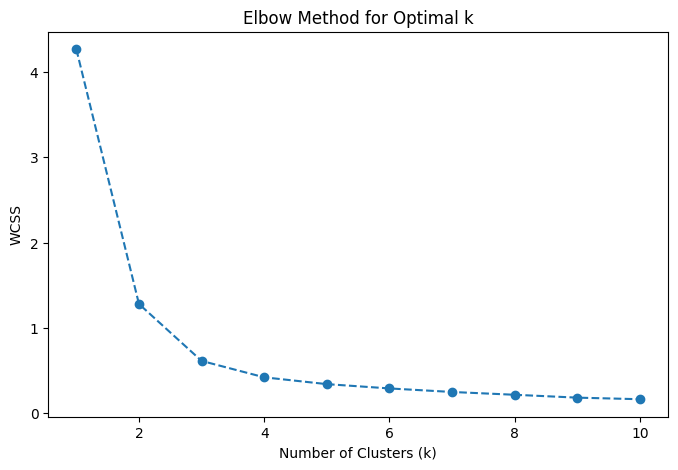

2024-12-25 23:39:10.561 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:10.754 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:11.331 
  command:

    streamlit run /home/samrawit/anaconda3/envs/kifiya/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-25 23:39:11.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [11]:
# Elbow method to find optimal k

wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

    print ( k, wcss)

plot_elbow_curve(k_values, wcss)




Perform K-means Clustering

In [12]:
# Choose the optimal k based on the elbow plot
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original data
user_engagement['Cluster'] = clusters

# Display the first few rows with cluster labels
user_engagement.head()


,IMSI,Total_Duration,Total_Download,Total_Upload,Session_Frequency,Total_Traffic,Cluster
0,204047108489451,104608.438950,78697597.0,60456049.0,1,1.391536e+08,0
1,204080810288647,104608.438950,194828056.0,37295915.0,1,2.321240e+08,0
2,208200101016140,86019.000000,31376981.0,53794658.0,1,8.517164e+07,0
3,208200101127285,86254.000000,392918313.0,33583272.0,1,4.265016e+08,0
4,208200101148045,193907.613676,961767023.0,71325004.0,2,1.033092e+09,2


Perform PCA

In [13]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Display the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.93657445 0.0526391 ]


Visualize Cluster

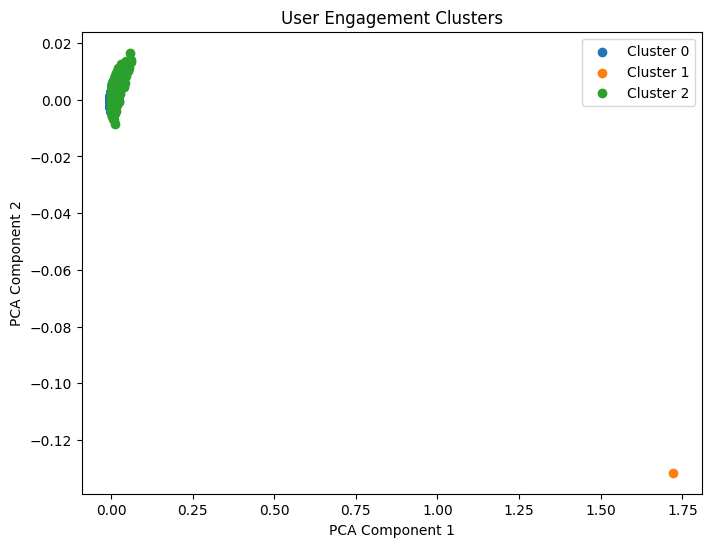

In [14]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    cluster_points = pca_features[user_engagement['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('User Engagement Clusters')
plt.legend()
plt.show()


In [15]:
# Apply KMeans clustering on PCA-transformed data
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(pca_features)

# Count the number of users in each cluster
cluster_counts = user_engagement['Cluster'].value_counts()

# Display the counts
print("Number of users in each cluster:")
print(cluster_counts)


Number of users in each cluster:
Cluster
0    91831
2    15433
1        1
Name: count, dtype: int64


Cluster summary

In [16]:
# Compute summary statistics for each cluster
# Analyze the characteristics of each cluster
cluster_summary = user_engagement.groupby('Cluster').mean()
print(cluster_summary)



                 IMSI  Total_Duration  Total_Download  Total_Upload  \
Cluster                                                               
0        2.082016e+14    9.158657e+04    5.125692e+08  4.733018e+07   
1        2.082014e+14    3.359534e+07    2.657735e+11  2.421693e+10   
2        2.082017e+14    2.832215e+05    1.351743e+09  1.161970e+08   

         Session_Frequency  Total_Traffic  
Cluster                                    
0                 1.151724   5.598994e+08  
1               588.000000   2.899904e+11  
2                 2.828290   1.467940e+09  


In [17]:
# Aggregate metrics by 'MSISDN/Number' (customer ID)
aggregated_data = telecom_data.groupby('MSISDN/Number').agg(
    session_frequency=('Bearer Id', 'count'),  # Count of sessions by customer
    total_session_duration=('Dur. (ms)', 'sum'),  # Total session duration (in ms)
    total_dl_traffic=('Total DL (Bytes)', 'sum'),  # Total data traffic from DL
    total_ul_traffic=('Total UL (Bytes)', 'sum')   # Total data traffic from UL
).reset_index()

# Add the total traffic by combining 'Total DL (Bytes)' and 'Total UL (Bytes)'
aggregated_data['total_traffic'] = aggregated_data['total_dl_traffic'] + aggregated_data['total_ul_traffic']

# Display the top 10 customers by each metric
top_10_session_frequency = aggregated_data.nlargest(10, 'session_frequency')
top_10_total_session_duration = aggregated_data.nlargest(10, 'total_session_duration')
top_10_total_traffic = aggregated_data.nlargest(10, 'total_traffic')

print("Top 10 customers by session frequency:")
print(top_10_session_frequency)

print("\nTop 10 customers by total session duration:")
print(top_10_total_session_duration)

print("\nTop 10 customers by total traffic:")
print(top_10_total_traffic)





Top 10 customers by session frequency:
       MSISDN/Number  session_frequency  total_session_duration  \
13526    33626320676               1084            6.268178e+07   
6437     33614892860                 17            1.831395e+06   
13180    33625779332                 17            1.766587e+06   
37052    33659725664                 16            1.818410e+06   
76363    33675877202                 15            1.524449e+06   
92923    33760536639                 15            1.631872e+06   
65118    33667163239                 13            1.428216e+06   
666      33603127838                 12            1.310040e+06   
1279     33604515716                 12            1.375127e+06   
13994    33627080969                 12            1.377434e+06   

       total_dl_traffic  total_ul_traffic  total_traffic  
13526      4.946810e+11      4.503610e+10   5.397171e+11  
6437       8.156743e+09      6.894830e+08   8.846226e+09  
13180      7.770043e+09      7.295774e+08   8.

In [18]:
# Calculate the average, mode, max, and min for the 'session_frequency' column
average_session_frequency = aggregated_data['session_frequency'].mean()
mode_session_frequency = aggregated_data['session_frequency'].mode()[0]  # mode() returns a Series, so [0] accesses the first mode
max_session_frequency = aggregated_data['session_frequency'].max()
min_session_frequency = aggregated_data['session_frequency'].min()

# Print the results
print(f"Average session frequency: {average_session_frequency}")
print(f"Mode session frequency: {mode_session_frequency}")
print(f"Max session frequency: {max_session_frequency}")
print(f"Min session frequency: {min_session_frequency}")


Average session frequency: 1.403767687354945
Mode session frequency: 1
Max session frequency: 1084
Min session frequency: 1


/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


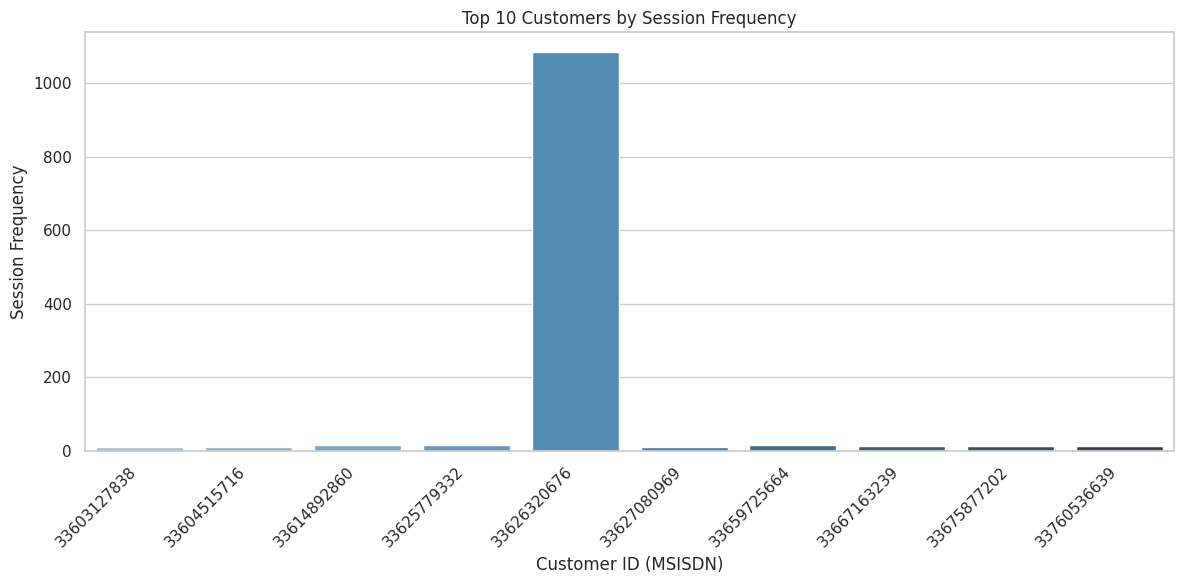

2024-12-25 23:39:14.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:14.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:14.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right

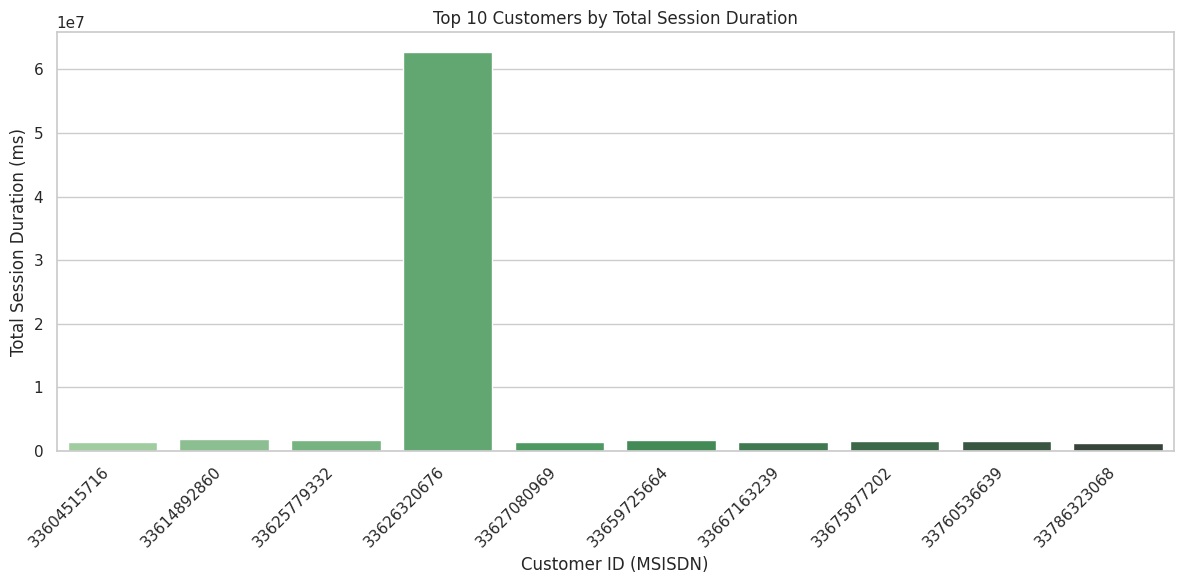

2024-12-25 23:39:14.986 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:15.419 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:15.420 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right

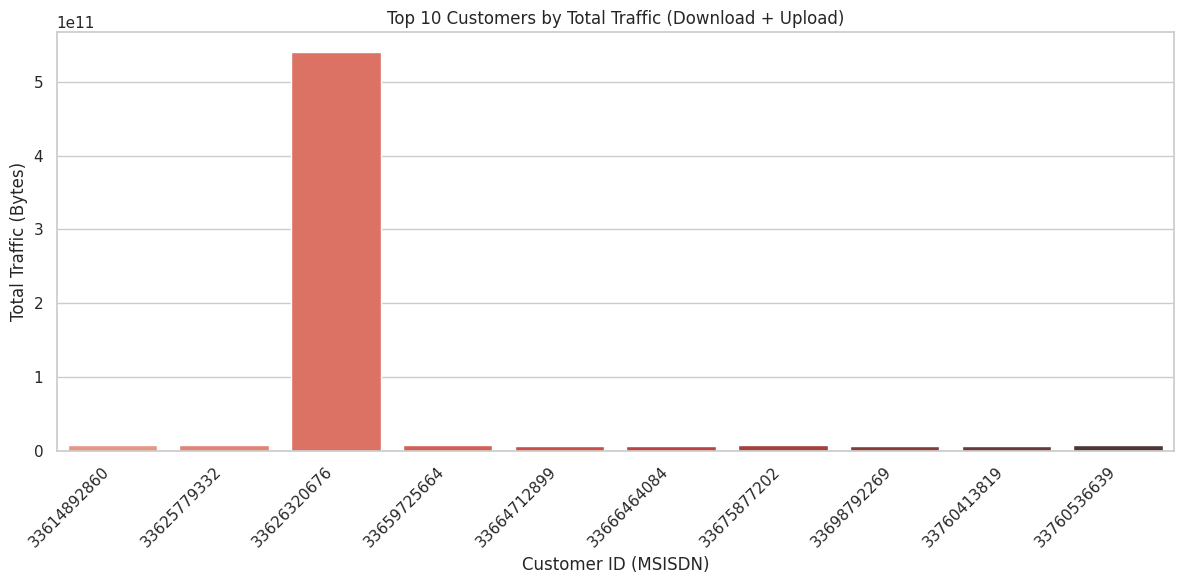

2024-12-25 23:39:15.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:16.248 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:39:16.249 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [19]:
top_10_session_frequency['MSISDN/Number'] = top_10_session_frequency['MSISDN/Number'].astype(int)


# Set up the visual style
sns.set(style="whitegrid")

# 1. Top 10 customers by session frequency
plot_bar_chart(data=top_10_session_frequency, x_col='MSISDN/Number', y_col='session_frequency', 
               x_label='Customer ID (MSISDN)', y_label='Session Frequency', 
               title='Top 10 Customers by Session Frequency', color_palette='Blues_d')

# 2. Top 10 customers by total session duration
plot_bar_chart(data=top_10_total_session_duration, x_col='MSISDN/Number', y_col='total_session_duration', 
               x_label='Customer ID (MSISDN)', y_label='Total Session Duration (ms)', 
               title='Top 10 Customers by Total Session Duration', color_palette='Greens_d')

# 3. Top 10 customers by total traffic
plot_bar_chart(data=top_10_total_traffic, x_col='MSISDN/Number', y_col='total_traffic', 
               x_label='Customer ID (MSISDN)', y_label='Total Traffic (Bytes)', 
               title='Top 10 Customers by Total Traffic (Download + Upload)', color_palette='Reds_d')


In [20]:
# Applications we are interested
applications = ['Google', 'YouTube', 'Games', 'Netflix', 'Email', 'Social Media', 'Other']

# Initialize an empty DataFrame to store results
aggregated_data = pd.DataFrame()

# Loop over each application and aggregate the data
for app in applications:
    if app == 'Google':
        app_data = telecom_data[['MSISDN/Number', 'Google DL (Bytes)', 'Google UL (Bytes)', 'Start', 'Dur. (ms)']]
    elif app == 'YouTube':
        app_data = telecom_data[['MSISDN/Number', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Start', 'Dur. (ms)']]
    elif app == 'Games':
        app_data = telecom_data[['MSISDN/Number', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Start', 'Dur. (ms)']]

    # Aggregate data by MSISDN (customer ID)
    app_aggregated = app_data.groupby('MSISDN/Number').agg(
        session_frequency=('Start', 'count'),
        total_session_duration=('Dur. (ms)', 'sum'),
        total_upload_traffic=('Google UL (Bytes)' if app == 'Google' else 'Youtube UL (Bytes)' if app == 'YouTube' else 'Gaming UL (Bytes)', 'sum'),
        total_download_traffic=('Google DL (Bytes)' if app == 'Google' else 'Youtube DL (Bytes)' if app == 'YouTube' else 'Gaming DL (Bytes)', 'sum')
    ).reset_index()

    # Calculate the total traffic (upload + download)
    app_aggregated['total_traffic'] = app_aggregated['total_upload_traffic'] + app_aggregated['total_download_traffic']
    
    # Add the application name for tracking
    app_aggregated['App_Name'] = app
    
    # Append the aggregated data to the overall DataFrame
    aggregated_data = pd.concat([aggregated_data, app_aggregated])

# View aggregated data
print(aggregated_data.head())


   MSISDN/Number  session_frequency  total_session_duration  \
0    33601001722                  1            116720.00000   
1    33601001754                  1             86897.39577   
2    33601002511                  1            134969.00000   
3    33601007832                  1             49878.00000   
4    33601008617                  2             37104.00000   

   total_upload_traffic  total_download_traffic  total_traffic App_Name  
0             1051882.0               3337123.0      4389005.0   Google  
1             1137166.0               4197697.0      5334863.0   Google  
2               99643.0               3343483.0      3443126.0   Google  
3             3740728.0               5937765.0      9678493.0   Google  
4             4770948.0              13728668.0     18499616.0   Google  


In [21]:
# Aggregating the total traffic per application
app_engagement = aggregated_data.groupby(['App_Name', 'MSISDN/Number']).agg(
    total_traffic=('total_traffic', 'sum'),
    total_session_frequency=('session_frequency', 'sum'),
    total_session_duration=('total_session_duration', 'sum')
).reset_index()

# Sorting and displaying the top 10 most engaged users per application
top_10_google = app_engagement[app_engagement['App_Name'] == 'Google'].sort_values(by='total_traffic', ascending=False).head(10)
print("Top 10 most engaged Google users:")
print(top_10_google)

top_10_youtube = app_engagement[app_engagement['App_Name'] == 'YouTube'].sort_values(by='total_traffic', ascending=False).head(10)
print("Top 10 most engaged YouTube users:")
print(top_10_youtube)

top_10_games = app_engagement[app_engagement['App_Name'] == 'Games'].sort_values(by='total_traffic', ascending=False).head(10)
print("Top 10 most engaged Games users:")
print(top_10_games)


Top 10 most engaged Google users:
       App_Name  MSISDN/Number  total_traffic  total_session_frequency  \
227238   Google    33626320676   8.400769e+09                     1084   
226892   Google    33625779332   1.423079e+08                       17   
220149   Google    33614892860   1.279738e+08                       17   
306635   Google    33760536639   1.232231e+08                       15   
250764   Google    33659725664   1.165163e+08                       16   
319849   Google    33786323068   1.102545e+08                       12   
290075   Google    33675877202   1.098605e+08                       15   
278830   Google    33667163239   1.050327e+08                       13   
308366   Google    33761268199   9.708999e+07                       10   
300025   Google    33698756430   9.193515e+07                       10   

        total_session_duration  
227238            6.268178e+07  
226892            1.766587e+06  
220149            1.831395e+06  
306635            1

/tmp/ipykernel_81276/2951074775.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App_Name', y='total_traffic', data=top_3_apps, palette='viridis')


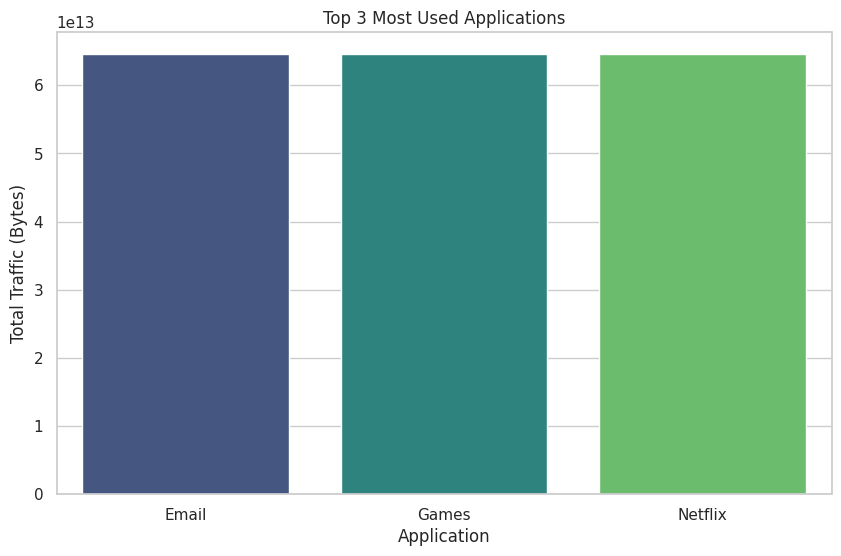

In [22]:
# Aggregating total traffic per application
app_usage = aggregated_data.groupby('App_Name').agg(
    total_traffic=('total_traffic', 'sum')
).reset_index()

# Sorting the applications by total traffic
top_3_apps = app_usage.sort_values(by='total_traffic', ascending=False).head(3)

# Plot the top 3 most used applications
plt.figure(figsize=(10, 6))
sns.barplot(x='App_Name', y='total_traffic', data=top_3_apps, palette='viridis')

plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.show()
